<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1> 

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||    
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||
    
<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

## <b> Librerías necesarias: </b>


In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import argparse
import cv2
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy import stats
import operator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## <b> Montaje de unidad Google Drive en el entorno de ejecución: </b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Mounted at /content/drive
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


## <b> Verificación presencia de GPU: </b>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
dataPath = "all-mias"

mob_dn_folder = '/01_mobile_densenet_DFV'

dataPath01 = dataPath + mob_dn_folder

if os.path.isdir(dataPath01) is False:
  os.mkdir(dataPath01)

textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


## <b> Reemplazo (llenado) de valores vacíos o nulos: </b>

In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
#mias_df.head()

## <b> Cambio de números decimales a enteros: </b>

In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head()
print(mias_df)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        B  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


Hay 330 filas, porque hay 330 etiquetas en total. Pero hay 322 imágenes porque algunas imágenes tienen más de una anomalía sea benigna o maligna.

Las que aparecen más de una vez son:

mdb005 2 veces         

mdb132 2 veces

mdb144 2 veces (B y M)

mdb223 2 veces

mdb226 3 veces 

mdb239 2 veces 

mdb249 2 veces 

Es decir, hay 8 repetidas en la lista.

In [ ]:
#Drop a las anormales que no están marcadas por experto:
mias_df_new = mias_df.drop(mias_df[(mias_df['SEVERITY'] != 'N') & (mias_df['RADIUS'] == 0)].index)
print(mias_df_new)

print("\nLabeled abnormalities (more than one in some images) and labeled as normal: ", mias_df_new.shape) 

#Split by class:
abnormalClass = mias_df_new[mias_df_new.SEVERITY!='N']
print("Labeled as abnormal: ", abnormalClass.shape)
normalClass = mias_df_new[mias_df_new.SEVERITY=='N']
print("Labeled as normal: ", normalClass.shape)

#Unique REFNUM:
mias_df_uniques = mias_df_new.drop_duplicates(subset = ["REFNUM"]) #REFNUM únicos porque se repiten para número de imgs no de anormalidades presentes
abnormal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY!='N']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("\nNumber of images: ", mias_df_uniques.shape) 
print("Number of abnormal images: ", abnormal_uniques.shape) 
print("Number of normal images: ", normal_uniques.shape) 

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        B  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[326 rows x 7 columns]

Labeled abnormalities (more than one in some images) and labeled as normal:  (326, 7)
Labeled as abnormal:  (117, 7)
Labeled as normal:  (209, 7)

Number of images:  (318, 7)
Number of abnormal images:  (109, 7)
Number of normal images:  (209, 7)


In [ ]:
orig_path = dataPath+'/01_allmias_mat_proc_eq/'
#comp_name = '_processed.png'
comp_name = '_output.png'

abnormal_fileNames = abnormalClass.REFNUM
normal_fileNames = normalClass.REFNUM

abnormal_path = dataPath01+'/abnormal/'
normal_path = dataPath01+'/normal/'

'''
# Descomentar si se van a generar las carpetas nuevamente desde cero:

if os.path.isdir(abnormal_path) is False:
    os.makedirs(abnormal_path)
    os.makedirs(normal_path)

    for image_name in abnormal_fileNames:  
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)
        shutil.copy(orig_path + image_name + comp_name, abnormal_path)        

    for image_name in normal_fileNames:  
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)
        shutil.copy(orig_path + image_name + comp_name, normal_path)  
'''     

"\n# Descomentar si se van a generar las carpetas nuevamente desde cero:\n\nif os.path.isdir(abnormal_path) is False:\n    os.makedirs(abnormal_path)\n    os.makedirs(normal_path)\n\n    for image_name in abnormal_fileNames:  \n        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)\n        shutil.copy(orig_path + image_name + comp_name, abnormal_path)        \n\n    for image_name in normal_fileNames:  \n        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)\n        shutil.copy(orig_path + image_name + comp_name, normal_path)  \n"

In [ ]:
#Number of images: 318
#Number of abnormal images: 109
#Number of normal images: 209

#Train: aprox. 70%
#Valid: aprox. 15%
#Test : aprox. 15% :

if os.path.isdir(dataPath01+'/train/abnormal') is False:
    os.makedirs(dataPath01+'/train/abnormal')
    os.makedirs(dataPath01+'/train/normal')
    os.makedirs(dataPath01+'/valid/abnormal')
    os.makedirs(dataPath01+'/valid/normal')
    os.makedirs(dataPath01+'/test/abnormal')
    os.makedirs(dataPath01+'/test/normal')
    
    #train:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 77):  
        shutil.move(c, dataPath01+'/train/abnormal')      
    for c in random.sample(glob.glob(normal_path+'/*.png'), 147):
        shutil.move(c, dataPath01+'/train/normal')
    #valid:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 16):
        shutil.move(c, dataPath01+'/valid/abnormal')        
    for c in random.sample(glob.glob(normal_path+'/*.png'), 31):
        shutil.move(c, dataPath01+'/valid/normal')
    #test:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 16):
        shutil.move(c, dataPath01+'/test/abnormal')      
    for c in random.sample(glob.glob(normal_path+'/*.png'), 31):
        shutil.move(c, dataPath01+'/test/normal')

    shutil.rmtree(abnormal_path)
    shutil.rmtree(normal_path)

## <b> Data Augmentation </b>

In [ ]:
def augmentImages(images_paths, dir, imgs_per_image, pixel_fill):
  #images_paths = glob.glob(images_path+'/*.png')

  #Trataré de meter las imágenes a un arreglo para que sean leídas más rápido cuando haga el augmentation:
  imgs_arr=[]
  imgs_names_arr=[]
  for myFile in images_paths:
    image = cv2.imread(myFile)
    imgs_arr.append(image)
    basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto  
    imgs_names_arr.append(name) 

  for myImage, myName in zip(imgs_arr, imgs_names_arr):
    image = np.expand_dims(myImage,0)
    #min_pixel = np.min(image)
    #min_pixel = 239 #np.max(image) 
    #gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=pixel_fill, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])

    gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
                              cval=pixel_fill, shear_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])
    #gen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=min_pixel, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)

    #Save augmented images
    aug_iter = gen.flow(image, save_to_dir=dir, save_prefix='aug_'+myName, save_format='png', seed=1)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(imgs_per_image)]

In [ ]:
image = cv2.imread(orig_path + 'mdb001' + comp_name)
pix_fill = image[0][0][0]

#Anormales para train:
train_abnormal_path = dataPath01+'/train/abnormal/'
if len(os.listdir(train_abnormal_path)) == 77:
  train_images_paths = glob.glob(train_abnormal_path+'*.png')
  augmentImages(train_images_paths, train_abnormal_path, 3, pix_fill) # actualizar estos números: (x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

#Normales para train:
train_normal_path = dataPath01+'/train/normal/'
if len(os.listdir(train_normal_path)) == 147:
  train_images_paths = glob.glob(train_normal_path+'*.png')
  augmentImages(train_images_paths, train_normal_path, 1, pix_fill) #(x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

In [ ]:
def remove_surplus(abnormal_path, normal_path):
  a = len(os.listdir(abnormal_path))
  b = len(os.listdir(normal_path))
  if  a > b:
    dif = a - b
    for c in random.sample(glob.glob(abnormal_path+'aug'+'*.png'), dif):
      os.remove(c) #Elimino las sobrantes para que quede la misma cantidad de imágenes que en /normal_processed   

In [ ]:
remove_surplus(train_abnormal_path, train_normal_path)

In [ ]:
train_path = (dataPath01+'/train/')
valid_path = (dataPath01+'/valid/')
test_path = (dataPath01+'/test/')

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory= train_path, target_size=(224,224), batch_size=49)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=1)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)

Found 588 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [ ]:
test_labels = test_batches.classes
print(test_labels)
print(test_batches.class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
{'abnormal': 0, 'normal': 1}


In [ ]:
'''assert train_batches.n == 40
assert valid_batches.n == 7
assert test_batches.n == 5
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3'''

'assert train_batches.n == 40\nassert valid_batches.n == 7\nassert test_batches.n == 5\nassert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3'

In [ ]:
x_train=np.concatenate([train_batches.next()[0] for i in range(train_batches.__len__())])
y_train=np.concatenate([train_batches.next()[1] for i in range(train_batches.__len__())])
print(x_train.shape)
print(y_train.shape)

(588, 224, 224, 3)
(588, 2)


## <b> Densenet 121 </b>

In [ ]:
model_dn121 = tf.keras.applications.densenet.DenseNet121(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    #classes=3
)
print(model_dn121.summary())

33188688/33188688 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
from tensorflow.keras.models import Model

x = model_dn121.layers[-2].output
#reshaped = tf.keras.layers.Reshape((1024,))(x)
output = Dense(units=2, activation='softmax')(x) # Este reshape se agrega porque Keras actualizó la implementación de MobileNet, por esto también cambia -6 a -5
model = Model(inputs=model_dn121.input, outputs=output)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
for layer in model.layers[:-20]:
    layer.trainable = False
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = dataPath01+'/checkpoints/dn121/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss', #'val_accuracy'
    mode='min',
    save_best_only=True)

epochs = 50

history_dn121 = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          #batch_size=10,
          epochs=epochs, #60 #35 puede ser suficiente en este caso
          verbose=2,
          callbacks=[model_checkpoint_callback]
          )

Epoch 1/50
12/12 - 20s - loss: 0.8109 - accuracy: 0.5323 - val_loss: 0.7314 - val_accuracy: 0.6596 - 20s/epoch - 2s/step
Epoch 2/50
12/12 - 11s - loss: 0.6441 - accuracy: 0.6361 - val_loss: 0.7409 - val_accuracy: 0.6596 - 11s/epoch - 937ms/step
Epoch 3/50
12/12 - 12s - loss: 0.5995 - accuracy: 0.6837 - val_loss: 0.6665 - val_accuracy: 0.6596 - 12s/epoch - 975ms/step
Epoch 4/50
12/12 - 12s - loss: 0.5431 - accuracy: 0.7347 - val_loss: 0.6171 - val_accuracy: 0.6596 - 12s/epoch - 983ms/step
Epoch 5/50
12/12 - 12s - loss: 0.4939 - accuracy: 0.7942 - val_loss: 0.6057 - val_accuracy: 0.6596 - 12s/epoch - 974ms/step
Epoch 6/50
12/12 - 12s - loss: 0.4437 - accuracy: 0.8452 - val_loss: 0.5748 - val_accuracy: 0.6596 - 12s/epoch - 965ms/step
Epoch 7/50
12/12 - 11s - loss: 0.4028 - accuracy: 0.8793 - val_loss: 0.5481 - val_accuracy: 0.6809 - 11s/epoch - 958ms/step
Epoch 8/50
12/12 - 11s - loss: 0.3654 - accuracy: 0.9014 - val_loss: 0.5284 - val_accuracy: 0.6809 - 11s/epoch - 958ms/step
Epoch 9/50


In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

#model_name = '01_dn121_DFV_1(15-11-22).h5'

#model.save(model_name)  # creates a HDF5 file 'my_model.h5'

#del model  # deletes the existing model

# returns a compiled model, identical to the previous one
#from keras.models import load_model
#model = load_model(model_name)

#print(model.summary())

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


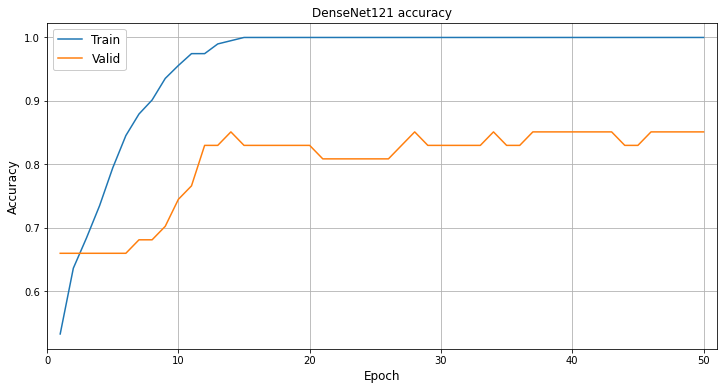

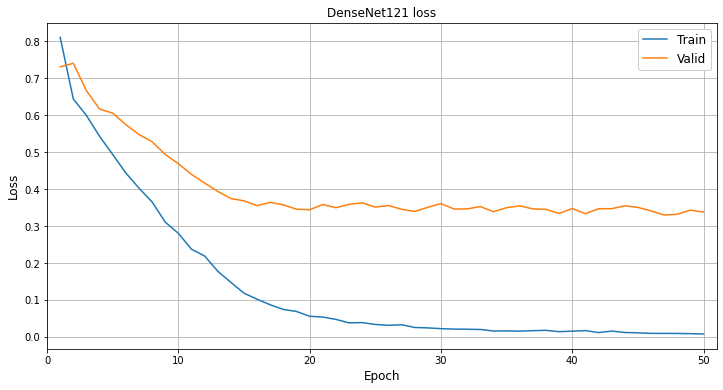

In [ ]:
# list all data in history
print(history_dn121.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('DenseNet121 accuracy', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Valid'], loc='upper left', framealpha=1, fontsize=12)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('DenseNet121 loss', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Valid'], loc='upper right', framealpha=1, fontsize=12)#, fancybox=True)
plt.grid()
plt.show()

#plt.savefig('01_DenseNet121_DFV.jpg', dpi=200)

## Confusion Matrix de Test

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.grid(False)

Confusion matrix, without normalization
[[13  3]
 [ 0 31]]


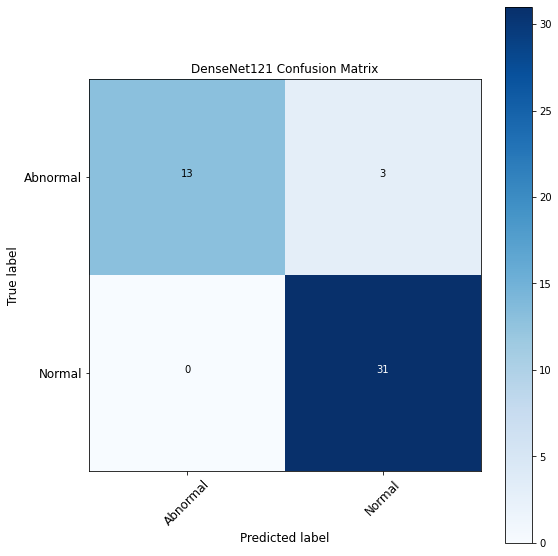

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='DenseNet121 Confusion Matrix')

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Accuracy DenseNet121 (Test): ',accuracy_score(test_labels, predictions.argmax(axis=1)))
print('Recall DenseNet121 (Test): ',recall_score(test_labels, predictions.argmax(axis=1)))
print('Precision DenseNet121 (Test): ',precision_score(test_labels, predictions.argmax(axis=1)))
print('F1 Score DenseNet121 (Test): ',f1_score(test_labels, predictions.argmax(axis=1)))

Accuracy DenseNet121 (Test):  0.9361702127659575
Recall DenseNet121 (Test):  1.0
Precision DenseNet121 (Test):  0.9117647058823529
F1 Score DenseNet121 (Test):  0.9538461538461539


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.91      1.00      0.95        31

    accuracy                           0.94        47
   macro avg       0.96      0.91      0.93        47
weighted avg       0.94      0.94      0.93        47



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[0.     0.1875 1.    ]
[0. 1. 1.]
ROC AUC:  0.90625


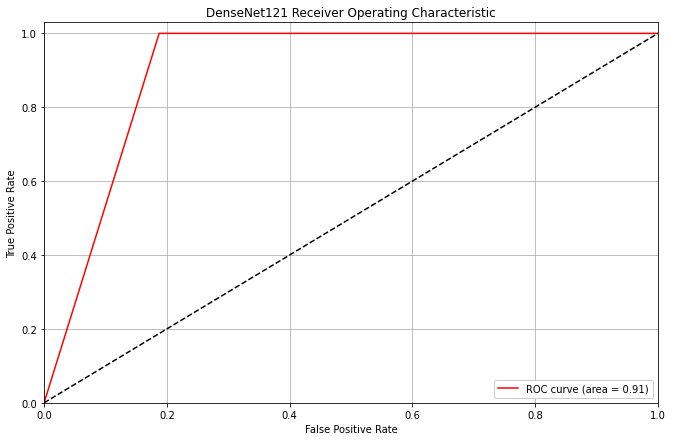

In [ ]:
import sklearn.metrics as metrics
##from sklearn.metrics import roc_curve, auc#, plot_roc_curve
#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels, predictions.argmax(axis=1))
print(test_labels)
#print(predictions)
print(predictions.argmax(axis=1))
print(false_positive_rate)
print(true_positive_rate)
#cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", roc_auc)

plt.figure(figsize=(11, 7))
plt.plot(false_positive_rate, true_positive_rate, 'r-', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet121 Receiver Operating Characteristic')
plt.legend(loc="lower right", framealpha=1)
plt.grid()
plt.show()

Mamografía:
/mdb001_output.png


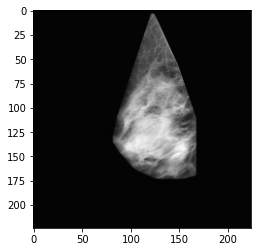

1/1 [==============================] - 2s 2s/step
[[9.9998403e-01 1.5985452e-05]]


In [ ]:
#mob_dn_folder = '/01_mobile_densenet_DFV'
#dataPath01 = dataPath + mob_dn_folder

img_size = (224, 224)

test_path = dataPath01+'/test/abnormal/mdb001_output.png'  

image = cv2.imread(test_path)
#image_0 = resize(image, (height_shape, width_shape), mode='constant')
#image = resize(image, (height_shape, width_shape), mode='constant', preserve_range=True)
image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)

print('Mamografía:')
print(test_path[45:])
#print(image_path[47:])
plt.imshow(image, cmap='gray')
plt.show()

image = np.expand_dims(image, axis=0)
pred = model.predict(image)
print(pred)

## Grad-Cam Configurable Parameters
Can change these to another model.

To get the values for last_conv_layer_name use model.summary() to see the names of all layers in the model.

In [ ]:
#model_builder = keras.applications.xception.Xception

#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions


preprocess_input = keras.applications.densenet.preprocess_input
decode_predictions = keras.applications.densenet.decode_predictions

last_conv_layer_name = "bn"



# conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']                                                                                                    
# bn (BatchNormalization)        (None, 7, 7, 1024)   4096        ['conv5_block16_concat[0][0]']   






# The local path to our target image
#img_path = keras.utils.get_file(
#    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#)

#display(Image(img_path))

## Grad-Cam

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Test Grad-Cam

1/1 [==============================] - 0s 32ms/step


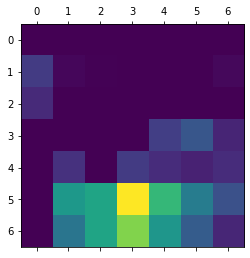

In [ ]:
img_size = (224, 224)

img_path = dataPath01+'/test/abnormal/mdb271_output.png'  

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

#img_array = cv2.resize(img_path, (224, 224), interpolation = cv2.INTER_AREA)

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Superimposed visualization

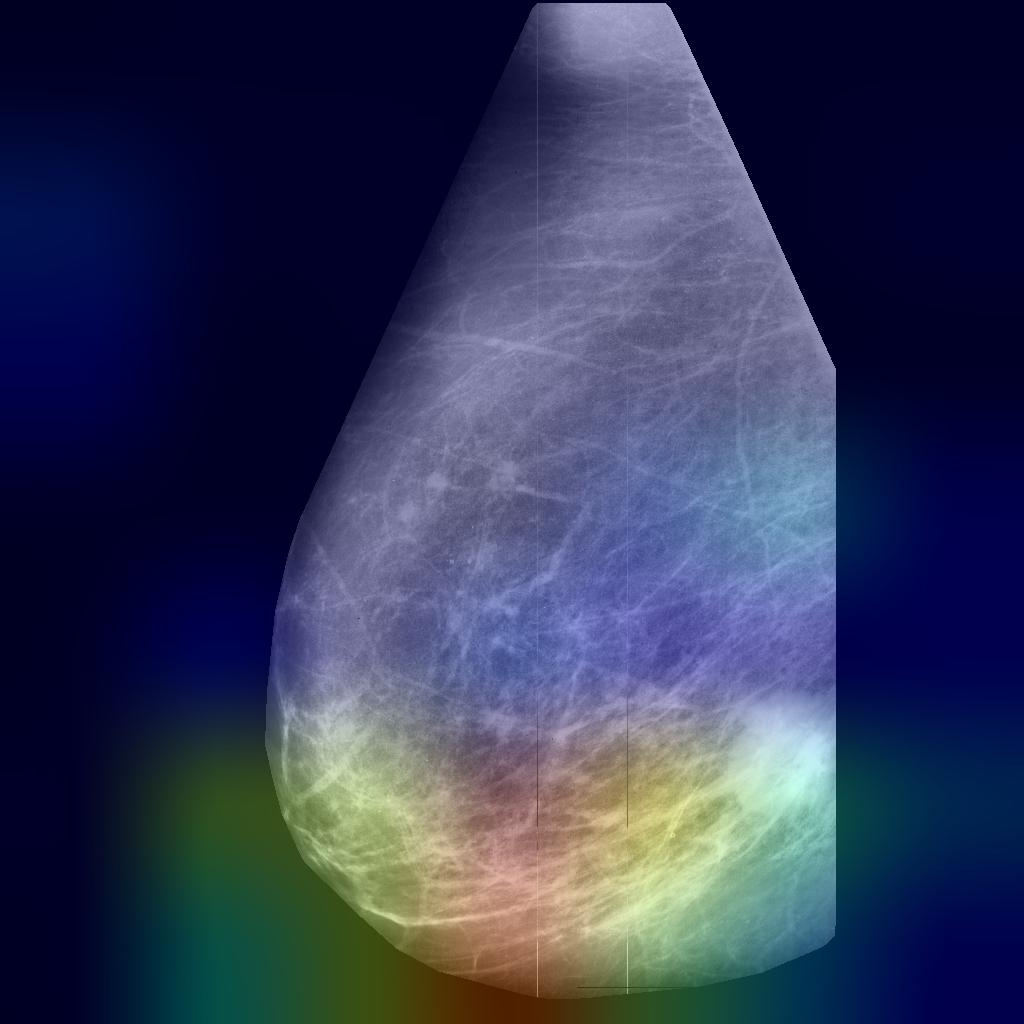

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)